In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gco
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from utils import rgb2gray

In [2]:
# Starting index is 1 maybe we need to shift everything by -1
def edges4connected(height, width):
    """ Construct edges for 4-connected neighborhood MRF. Assume row-major ordering.

      Args:
        height of MRF.
        width of MRF.

      Returns:
        A `nd.array` with dtype `int32/int64` of size |E| x 2.
    """
    edges = []
    lin_node_index = (width-1)*(height-1)
    
    for n in np.arange(lin_node_index):
        if(n%width):
            edges.append([n,n+1])
        if(n%height):
            edges.append([n,n+width])
    edges=np.array(edges)
            
    

    # sanity check
    assert (edges.dtype in [np.int32, np.int64])
    return edges


In [3]:
def negative_log_laplacian(x, s):
    """ Elementwise evaluation of a log Laplacian. """

    result = -np.log((1.0/(2*s)) * np.exp(-np.abs(x)/s))
    
    assert (np.equal(result.shape, x.shape).all())
    return result

In [4]:
def negative_stereo_loglikelihood(i0, i1, d, s, invalid_penalty=1000.0):
    """ Elementwise stereo negative log likelihood.

      Args:
        i0, i1                  stereo pair of images.
        d                       given disparities.
        invalid_penalty:        penalty value if disparity yields position outside of valid range.

      Returns:
        A `nd.array` with dtype `float32/float64`.
    """
    
    size = np.shape(i1)
    nllh = np.zeros(size)
    i1_d = np.zeros(size)
    
    for i in range(0, size[0] - 1):
        for j in range(0, size[1] - 1):
            shifted_index = j - d[i,j]
            # Penalize if shifted index is out of image range
            if shifted_index < 0 or shifted_index > size[1] - 1:
                nllh[i, j] = invalid_penalty
            # Otherwise asign cost  laplacian model
            else:
                x = i0[i, j] - i1[i, shifted_index]
                nllh[i, j] = negative_log_laplacian(x, s)
    
    assert (np.equal(nllh.shape, d.shape).all())
    assert (nllh.dtype in [np.float32, np.float64])
    return nllh


In [5]:
def alpha_expansion(i0, i1, edges, d0, candidate_disparities, s, lmbda):
    """ Run alpha-expansion algorithm.

      Args:
        i0, i1:                  Given grayscale images.
        edges:                   Given neighboor of MRF.
        d0:                      Initial disparities.
        candidate_disparities:   Set of labels to consider
        lmbda:                   Regularization parameter for Potts model.

      Runs through the set of candidates and iteratively expands a label.
      If there have been recorded changes, re-run through the complete set of candidates.
      Stops, if there are no changes anymore.

      Returns:
        A `nd.array` of type `int32`. Assigned labels (source=0 or target=1) minimizing the costs.


    """
    # --------------------------------------------------
    # 1. Initialize disparity map
    # 2. Repeatedly sweep through all disparities (in a random order)
    # 3. Treat intermediate solution as one disparity level and the 
    #    current proposed disparity as the other
    # 4. Solve binary graph-cuts problem
    # 5. Repeat until during one sweep no pixel has been updated
    # --------------------------------------------------
    
    # Initialize unary potentials
    unary = np.zeros((2,np.shape(d0)[0]*np.shape(d0)[1]))
    
    # Use standard Potts model (with lambda) for pairwise potentials
    pairwise = lil_matrix((np.shape(i1)[0]*np.shape(i1)[1], np.shape(i1)[0]*np.shape(i1)[1]))
    for pair in edges:
        p0 = pair[0] - 1
        p1 = pair[1] - 1
        pairwise[p0, p1] = lmbda
    pairwise = lil_matrix.tocsr(pairwise)
        
    iterations = 1
        
    # Repeat graph cut until no pixel has been updated
    change_flag = True
    d = d0
    while (change_flag):
        print("Iteration: ", iterations)
        candidate_disparities = np.random.permutation(candidate_disparities)
        change_flag = False
        for disparity_choice in candidate_disparities:
            # Randomly select disparity proposal from candidate list
            proposed_d = np.full(np.shape(d), fill_value=disparity_choice, dtype=np.int64)            

            # Calculate neg. log LHs for both disparities
            nllh_old = negative_stereo_loglikelihood(i0, i1, d, s, invalid_penalty=1000.0)
            nllh_new = negative_stereo_loglikelihood(i0, i1, proposed_d, s, invalid_penalty=1000.0)

            # Use the neg. log LH for unary potentials
            for a in range(0, np.shape(d0)[0]-1):
                for b in range(0, np.shape(d0)[1]-1):
                    # First row: potentials for each using 'old' disparity
                    unary[0, (a+1)*(b+1)] = nllh_old[a, b]
                    # Second row: potentials for each pixel using 'new' disparity
                    unary[1, (a+1)*(b+1)] = nllh_new[a, b]

            # Solve binary graph-cuts problem
            labels = gco.graphcut(unary, pairwise).reshape(np.shape(d))
            d_new = np.zeros(np.shape(d))
            for a in range(0, np.shape(d_new)[0]-1):
                for b in range(0, np.shape(d_new)[1]-1):
                    if labels[a,b] == 0:
                        d_new[a,b] = d[a,b]
                    else:
                        d_new[a,b] = proposed_d[a,b]


            if not((d==d_new).all()):
                change_flag = True

            # Use solution of graph-cats as intermediate solution for next iteration
            d = np.copy(d_new).astype(np.int64)
        iterations += 1
        plt.figure()
        plt.imshow(d,cmap="gray")
        plt.show()
    
    print("D:", d.dtype)
    print("D0: ", d0.dtype)
    assert (np.equal(d.shape, d0.shape).all())
    assert (d.dtype == d0.dtype)
    return d

In [6]:
def show_stereo(d, gt):
    """
    Visualize estimate and ground truth in one Figure.
    Only show the area for valid gt values (>0).
    """
    # TODO: Crop images to valid ground truth area

    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.title("Estimation:")
    plt.imshow(d, cmap="gray")
    plt.subplot(122)
    plt.title("Ground Truth:")
    plt.imshow(gt, cmap="gray")
    plt.show
    

    return

In [7]:
def evaluate_stereo(d, gt):
    """Computes percentage of false labels in the valid region (gt > 0)."""

    result = []

    return result

In [ ]:
def problem1():
    # Read stereo images and ground truth disparities
    i0 = rgb2gray(plt.imread('i0.png')).squeeze().astype(np.float32)
    i1 = rgb2gray(plt.imread('i1.png')).squeeze().astype(np.float32)
    gt = (255 * plt.imread('gt.png')).astype(np.int32)
    
    # Set Potts penalty
    lmbda = 3.0
    s = 10.0 / 255.0

    # Create 4 connected edge neighborhood
    edges = edges4connected(i0.shape[0], i0.shape[1])

    # Candidate search range
    candidate_disparities = np.arange(0, gt.max() + 1)

    """
    # Graph cuts with zero initialization
    zero_init = np.zeros(gt.shape).astype(np.int64)
    estimate_zero_init = alpha_expansion(i0, i1, edges, zero_init, candidate_disparities, s, lmbda)
    show_stereo(estimate_zero_init, gt)
    perc_correct = evaluate_stereo(estimate_zero_init, gt)
    print("Correct labels (zero init): %3.2f%%" % (perc_correct*100))
    """

    # Graph cuts with random initialization
    random_init = np.random.randint(low=0, high=gt.max() + 1, size=i0.shape)
    estimate_random_init = alpha_expansion(i0, i1, edges, random_init, candidate_disparities, s, lmbda)
    show_stereo(estimate_random_init, gt)
    perc_correct = evaluate_stereo(estimate_random_init, gt)
    print("Correct labels (random init): %3.2f%%" % (perc_correct*100))


Iteration:  1


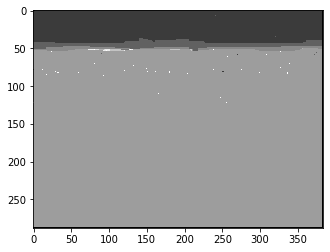

Iteration:  2


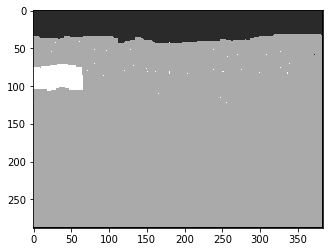

Iteration:  3


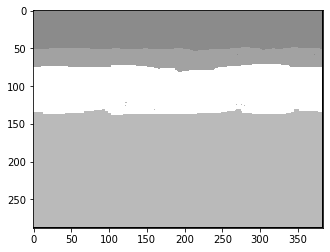

Iteration:  4


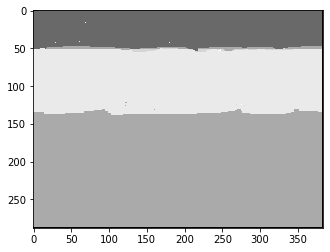

Iteration:  5


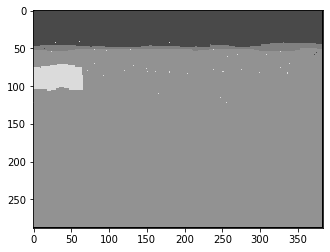

Iteration:  6


In [ ]:
problem1()